In [68]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import pandas as pd
from datasets import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy = evaluate.load("accuracy")
import sys
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure

In [69]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from transformers import logging

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=UndefinedMetricWarning)


In [70]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


In [71]:
test_env = False

fp = "../ab_data/experiment_data/"
model_fp = '../models/scenario_level/'

dataset_fp = [fp+'conduction_anomic.csv', fp+'conduction_anomic_control.csv', 
              fp+'control_anomic.csv', fp+'wernicke_anomic.csv', 
              fp+'wernicke_anomic_control.csv', fp+'control_conduction.csv',
              fp+'control_wernicke.csv', fp+'anomic_conduction_wernicke.csv']

fnames = [model_fp+'conduction_anomic', model_fp+'conduction_anomic_control',
          model_fp+'control_anomic', model_fp+'wernicke_anomic',
          model_fp+'wernicke_anomic_control', model_fp+'control_conduction',
          model_fp+'control_wernicke', model_fp+'anomic_conduction_wernicke']

ids2labels = [{0: "ANOMIC", 1: "CONDUCTION"}, {0: "CONTROL", 1: "ANOMIC", 2: "CONDUCTION"},
              {0: "CONTROL", 1: "ANOMIC"}, {0: "ANOMIC", 1: "WERNICKE"}, 
              {0: "CONTROL", 1: "ANOMIC", 2: "WERNICKE"}, {0: "CONTROL", 1: "CONDUCTION"},
              {0: "CONTROL", 1:"WERNICKE"}, {0: "CONDUCTION", 1: "ANOMIC", 2: "WERNICKE"}]

In [72]:
# non-binary classification metrics
def compute_metrics3(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metric_res={}

    # micro, macro and weighted scores since it is a multi-class
    # classification
    for met in metrics:
        if met != "accuracy":
            metric_res[met+"_micro"] = round(metric[met].compute(predictions=predictions, references=labels, average="micro")[met], 5)

            metric_res[met+"_macro"] = round(metric[met].compute(predictions=predictions, references=labels, average="macro")[met], 5)

            metric_res[met+"_weighted"] = round(metric[met].compute(predictions=predictions, references=labels, average="weighted")[met], 5)
        else:
            metric_res[met]=round(metric[met].compute(predictions=predictions, references=labels)[met], 5)
    print(metric_res)
    return metric_res

In [73]:
# binary classification metrics
def compute_metrics2(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metric_res={}
    for met in metrics:
       metric_res[met]=round(metric[met].compute(predictions=predictions,
       references=labels)[met], 5)
    print(metric_res)
    return metric_res

In [74]:
def def_model(id2label_):
    """
    Creates a distilbert uncased sequence classification model and tokenizer with new added tokens
    :param id2label_: (dict) aphasic groups and their corresponding ids
    :return: bert model and bert tokenizer
    """
    label2id = {v: k for k, v in id2label_.items()}
    tokenizer_ = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    if len(label2id) == 2:
        model_ = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label_, label2id=label2id)
    else:
        model_ = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3, id2label=id2label_, label2id=label2id)
        
    added_tokens = tokenizer_.add_tokens(["FP1"], special_tokens=True)
    added_tokens1 =  tokenizer_.add_tokens(["UP1"], special_tokens=True)
    added_tokens2 = tokenizer_.add_tokens(["FP2"], special_tokens=True)
    added_tokens3 =  tokenizer_.add_tokens(["UP2"], special_tokens=True)
    added_tokens4 = tokenizer_.add_tokens(["FP3"], special_tokens=True)
    added_tokens5 =  tokenizer_.add_tokens(["UP3"], special_tokens=True)
    
    print("We have added", added_tokens + added_tokens1 + added_tokens2 + added_tokens3 + added_tokens4 +
          added_tokens5, "tokens")
    model_.resize_token_embeddings(len(tokenizer_))
    
    return model_, tokenizer_

In [75]:
def def_dataset(dataset_filename_, id2label_, tokenizer, testing=False):
    """
    Creates a 70 train/ 30 test dataset with stratification and with fixed randomization (seed=42) 
    :param tokenizer: bert tokenizer
    :param dataset_filename_: (str) filepath of the datasest
    :param id2label_: (dict) aphasic groups and their corresponding ids
    :param testing: (bool) whether in testing or not
    :return: tokenized and split dataset as a Dataset instance 
    """
    label2id = {v: k for k, v in id2label_.items()}
    data = pd.read_csv(dataset_filename_).dropna()
    data["label"] = [label2id[x] for x in data["label"]]
    print(data['label'].unique())
    # for testing 
    if testing:
        data = data[:100]
    dataset = Dataset.from_pandas(data)
    def preprocess_function(examples):
        return tokenizer(examples["new_preprocessed_text"], padding=True, truncation=True, add_special_tokens=True, return_tensors="pt")
    tokenized_data = dataset.map(preprocess_function, batched=True).with_format("torch")
    tokenized_data_split_ = tokenized_data.train_test_split(test_size=0.3, seed=42)
    return tokenized_data_split_

In [76]:
def def_train_args(fname_):
    """
    Creates the training args for the training procedure
    :param fname_: (str) filepath to the model's save/log files
    :return: the training arguments 
    """
    training_args_ = TrainingArguments(
        output_dir=fname_+"/train",
        logging_dir=fname_+"/logs",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3 if "wernicke" in fname_ else 5, # 3 for wernicke including, otherwise 5
        weight_decay=0.01,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        use_cpu = False,
        log_level = 'warning'
    )
    return training_args_

## Train model

In [77]:
# # Train classifier
# 
# for dataset_filename, fname, id2label in zip(dataset_fp, fnames, ids2labels):
# 
#     print(f'Classifier: {list(id2label.values())}')
#     # define model, tokenizer, dataset and train args
#     model, tokenizer = def_model(id2label)
#     tokenized_data_split = def_dataset(dataset_filename, id2label, tokenizer, test_env)
#     data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#     training_args = def_train_args(fname)
# 
#     trainer = Trainer(
#             model=model,
#             args=training_args,
#             train_dataset=tokenized_data_split["train"],
#             eval_dataset=tokenized_data_split["test"],
#             tokenizer=tokenizer,
#             data_collator=data_collator,
#             compute_metrics=compute_metrics2 if len(id2label)==2 else compute_metrics3,
# 
#         )
# 
#     # saving train output to txtfile (overwrite existing one)
#     try:
#         os.remove(fname+"/train_data.txt")
#     except OSError:
#         pass
# 
#     orig_stdout = sys.stdout
#     sys.stdout = open(fname+"/train_data.txt",'wt')
#     print('Train results per epoch\n')
#     # train model
#     trainer.train()
#     print('\nTesting results\n')
#     # evaluate model 
#     trainer.evaluate()
#     sys.stdout.close()
#     sys.stdout=orig_stdout 
# 
#     # save trained model and tokenizer with new tokens 
#     trainer.save_model(fname+"/model")
#     tokenizer.save_pretrained(fname+"/tokenizer")

## Test model (test set)

In [78]:
def test_model(fname_, dataset_filename_, id2label_, test_env_):
    tokenizer = AutoTokenizer.from_pretrained(fname_+"/tokenizer", return_tensor="pt")
    model_ = AutoModelForSequenceClassification.from_pretrained(fname_+"/model")
    model_ = model_.to(device)
    tokenized_data_split_ = def_dataset(dataset_filename_, id2label_, tokenizer, test_env_)
    sentences = tokenized_data_split_["test"]["new_preprocessed_text"]
    true_labels = tokenized_data_split_["test"]["label"]
    pred_labels = []

    for sentence in sentences:
        inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt", add_special_tokens=True, max_length=512).input_ids.to(device)
        with torch.no_grad():
            logits = model_(inputs).logits
        predicted_class_id = logits.argmax().item()
        pred_labels.append(predicted_class_id)
    
    true_labels = [id2label[x.to(torch.int64).item()] for x in true_labels]
    pred_labels = [id2label[x] for x in pred_labels]
    cm = confusion_matrix(true_labels, pred_labels, normalize='true')
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize="true", cmap=plt.cm.Blues, ax=ax)
    plt.grid(False)
    figname = '_'.join(list(id2label.values())).lower()
    # plt.savefig('scenario_level_output/'+figname+'.png')
    plt.savefig('not_aphasic_output/'+figname+'.png')
    # saving test output to txtfile (overwrite existing one)
    try:
        os.remove('not_aphasic_output/'+figname+'.txt')
    except OSError:
        pass
    
    orig_stdout = sys.stdout
    sys.stdout = open('not_aphasic_output/'+figname+'.txt','wt')
    if len(id2label) == 2:
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall)/ (precision+recall)
        print("id2label=" + str(id2label))
        print("Accuracy: " + str(round(accuracy_score(true_labels, pred_labels),5)))
        print("Precision: " + str(round(precision, 5)))
        print("Recall: " + str(round(recall,5)))
        print("F1: " + str(round(f1,5)))
    else:
        report = classification_report(true_labels, pred_labels, labels=np.unique(pred_labels), output_dict=True)
        for k, v in report['macro avg'].items():
            report['macro avg'][k] = round(v, 4)
        for k, v in report['weighted avg'].items():
            report['weighted avg'][k] = round(v, 4)

        print("id2label=" + str(id2label))
        print("Accuracy: " + str(round(accuracy_score(true_labels, pred_labels),4)))       
        print("Macro avg: " + str(report['macro avg']))
        print("Weighted avg: " + str(report['weighted avg']))
    sys.stdout.close()
    sys.stdout=orig_stdout 

In [79]:
# test the trained model on test set

# for dataset_filename, fname, id2label in zip(dataset_fp, fnames, ids2labels):
    # test_model(fname, dataset_filename, id2label, test_env)

## Test models (on not aphasic dataset)

[0]


Map:   0%|          | 0/723 [00:00<?, ? examples/s]

[0]


Map:   0%|          | 0/723 [00:00<?, ? examples/s]

[0]


Map:   0%|          | 0/723 [00:00<?, ? examples/s]

[0]


Map:   0%|          | 0/723 [00:00<?, ? examples/s]

[0]


Map:   0%|          | 0/723 [00:00<?, ? examples/s]

C:\Users\imruh\AppData\Local\Temp\ipykernel_8472\3203108578.py:37: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


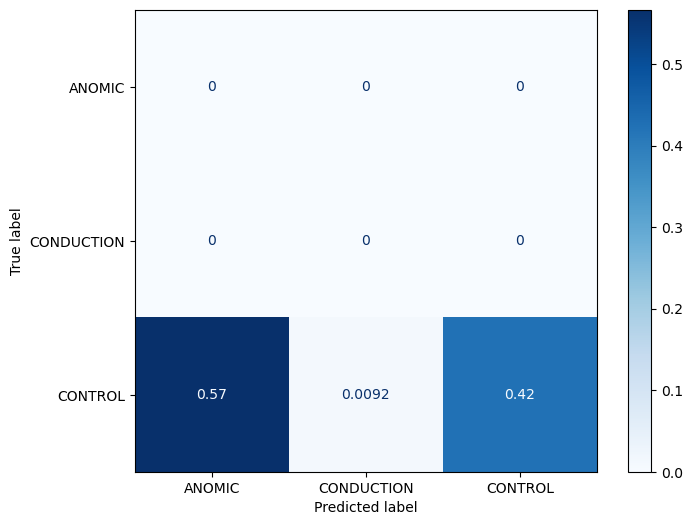

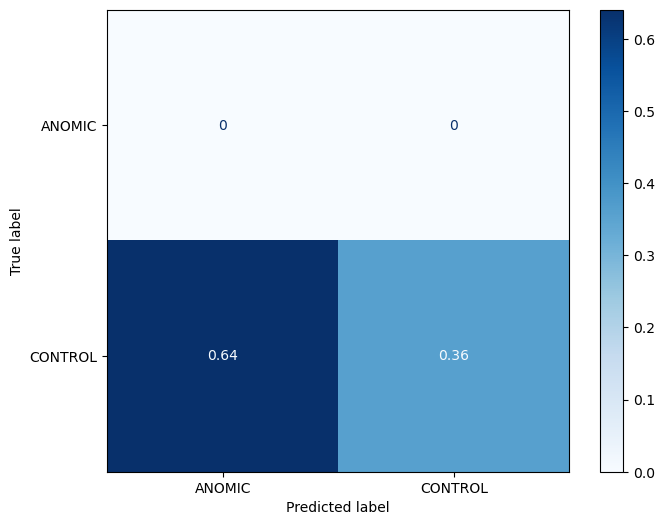

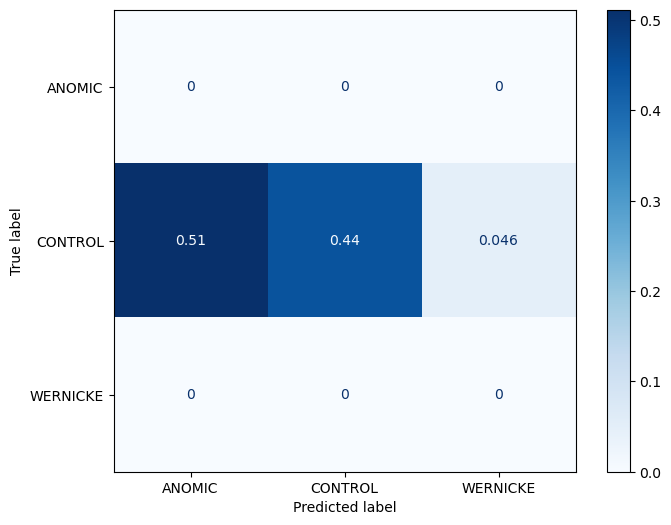

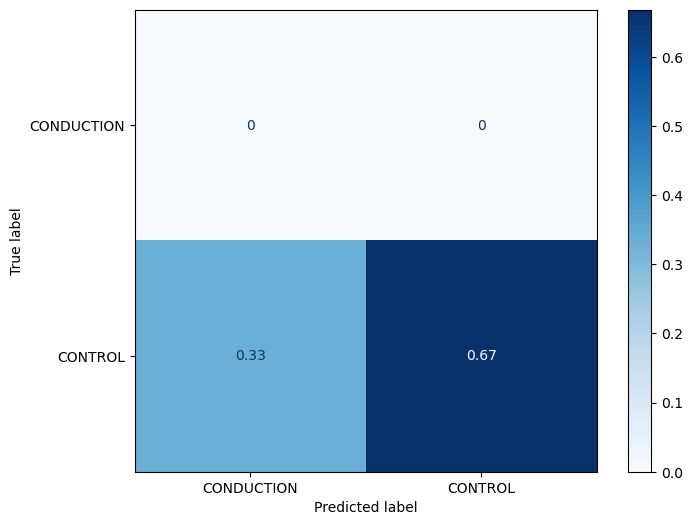

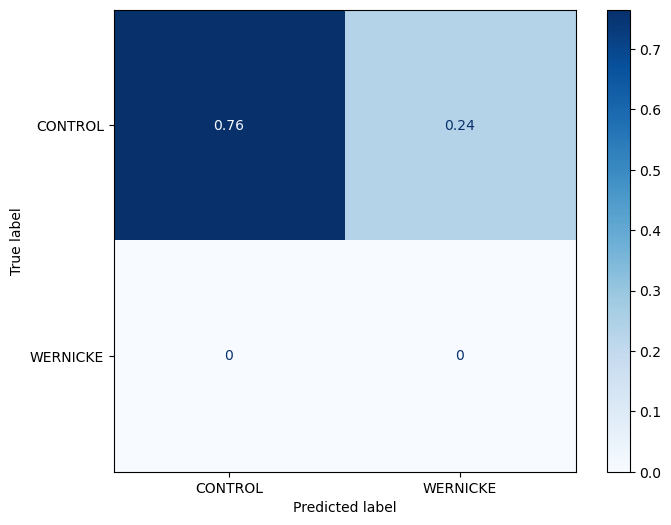

In [80]:
test_env = False

fp = "../ab_data/processed_data/"
model_fp = '../models/scenario_level/'

dataset_fp = fp + 'processeddata_not aphasic_para.csv'

fnames = [model_fp+'conduction_anomic_control',
          model_fp+'control_anomic', 
          model_fp+'wernicke_anomic_control', 
          model_fp+'control_conduction',
          model_fp+'control_wernicke']

# Here control = NOT APHASIC
ids2labels = [{0: "CONTROL", 1: "ANOMIC", 2: "CONDUCTION"},
              {0: "CONTROL", 1: "ANOMIC"}, 
              {0: "CONTROL", 1: "ANOMIC", 2: "WERNICKE"}, 
              {0: "CONTROL", 1: "CONDUCTION"},
              {0: "CONTROL", 1:"WERNICKE"}]

# df = pd.read_csv(dataset_fp)
# df['label'] = ['CONTROL']*len(df)
# df.to_csv(dataset_fp,index=None)

for id2label, model, in zip(ids2labels, fnames):
    test_model(model, dataset_fp, id2label, test_env)